# Predict House Price
#### Using xgBoost 

My original full House Price prediction can be found here: https://github.com/ScottySchmidt/Kaggle

##### Special Notes:
* Tunning learning_rate improved 8% better score
* Removing outliers improved 4% better score
* Removing similiar features makes couple percent better score
* Adding saleCondition improved .5% better score
* Tuning ETA have little to no effect
* early_stopping_rounds=5 makes little to no effect

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

data='/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
df=pd.read_csv(data)
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Missing Values

In [2]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
    print(findNA.head(10))
findNA() 

Missing data by column as a percent:
PoolQC          21.686567
MiscFeature     20.985075
Alley           20.432836
Fence           17.597015
FireplaceQu     10.298507
LotFrontage      3.865672
GarageYrBlt      1.208955
GarageCond       1.208955
GarageType       1.208955
GarageFinish     1.208955
dtype: float64


In [3]:
df=df.fillna(df.mean())
df=df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'])
print(df.shape)

(1460, 75)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'Enclos

# Encode Data

In [5]:
df['totalSQ']=df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF'].drop(columns=['1stFlrSF', '2ndFlrSF','TotalBsmtSF'])
df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,totalSQ
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,2566
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,2524
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,2706
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000,2473
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,3343


In [6]:
print(df['SaleCondition'].value_counts())
df['SaleCondition']=df['SaleCondition'].apply(lambda x:2 if x=='Normal' else 0)

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


In [7]:
print(df['Condition2'].value_counts())
df['Condition2']=df['Condition2'].apply(lambda x: 1 if x=='Norm' else 0)

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


In [8]:
df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
df.head()

,Id,MSSubClass,LotArea,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,totalSQ
0,1,60,8450,1,7,5,2003,2003,196.0,706,...,0,0,0,0,0,2,2008,2,208500,2566
1,2,20,9600,1,6,8,1976,1976,0.0,978,...,0,0,0,0,0,5,2007,2,181500,2524
2,3,60,11250,1,7,5,2001,2002,162.0,486,...,0,0,0,0,0,9,2008,2,223500,2706
3,4,70,9550,1,7,5,1915,1970,0.0,216,...,272,0,0,0,0,2,2006,0,140000,2473
4,5,60,14260,1,8,5,2000,2000,350.0,655,...,0,0,0,0,0,12,2008,2,250000,3343


# Outliers

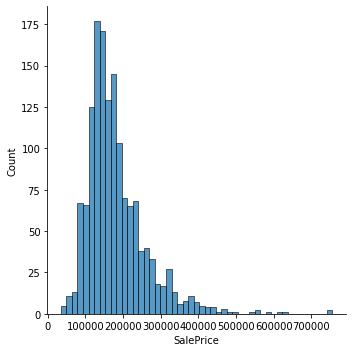

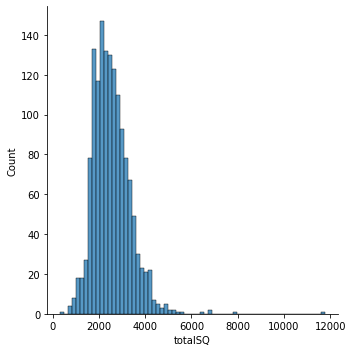

In [9]:
import seaborn as sns
sns.displot(df, x='SalePrice')
sns.displot(df, x='totalSQ')

In [10]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
priceOutlier=list(detect_outlier(df['SalePrice']))
print(priceOutlier)
sqOutlier=list(detect_outlier(df['totalSQ']))
print(sqOutlier)

[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500]
[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500, 5496, 6428, 7814, 6760, 5066, 5048, 5557, 6872, 11752, 5271, 5266]


In [11]:
#Remove Outliers:
df=df.loc[df['SalePrice']<500_000]
df=df.loc[df['totalSQ']<5000]
print(df.shape) 

(1444, 40)


# Correlations

<AxesSubplot:>

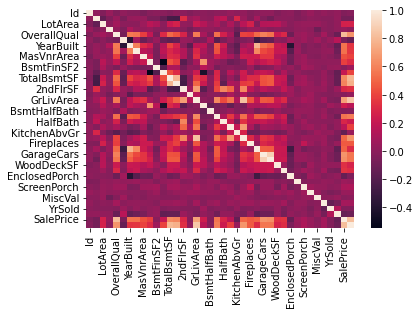

In [12]:
import seaborn as sns
sns.heatmap(df.corr())

In [13]:
#Too similiar variables:
df=df.drop(['GarageArea', 'GarageYrBlt', 'GrLivArea'], axis=1)

# Split Data

In [14]:
from sklearn.model_selection import train_test_split, cross_validate

X=df.drop("SalePrice", axis='columns')
y=df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

# xgBoost

In [15]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

xgbMSE=mean_absolute_error(y_test, y_pred)
xgR2 = r2_score(y_test, y_pred).round(4)
print(xgR2)
print(xgbMSE)

0.8873
16176.886931669287


### Max Depth Tunning
Four for max depth is clearly the magic number with the least amount of error and highest accuracy. 

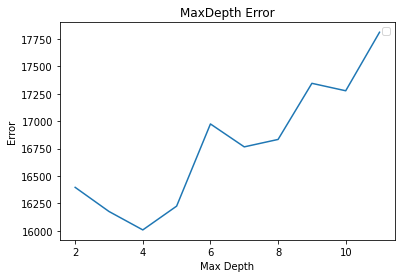

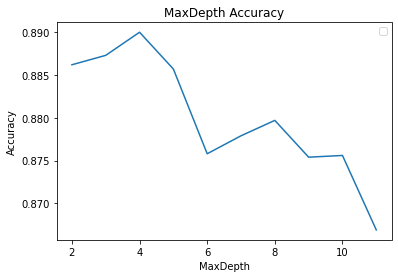

In [16]:
maxDepth=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
listMSE=[]
listR2=[]

for d in maxDepth:
    regressor = xgb.XGBRegressor(
        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=d
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(maxDepth, listMSE)
plt.title('MaxDepth Error')
plt.ylabel('Error')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

plt.plot(maxDepth, listR2)
plt.title('MaxDepth Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('MaxDepth')
plt.legend()
plt.show()

#### N Estimators Tunning
Around 100 n_estimators seems to be a fair number for both accuracy and low error.

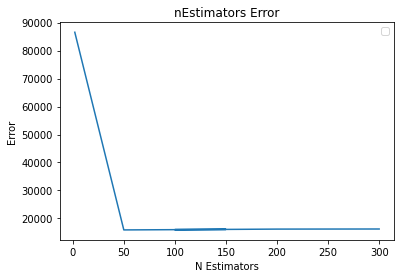

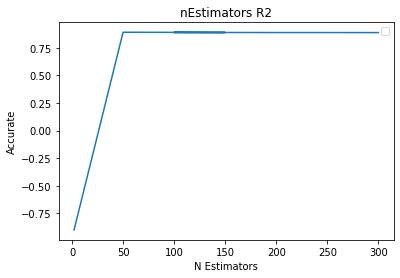

In [17]:
nEst=[2, 50, 150, 100, 150, 200, 300]
listMSE=[]
listR2=[]

for n in nEst:
    regressor = xgb.XGBRegressor(
        n_estimators=n,
        reg_lambda=1,
        gamma=0,
        max_depth=4
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(nEst, listMSE)
plt.title('nEstimators Error')
plt.ylabel('Error')
plt.xlabel('N Estimators')
plt.legend()
plt.show()

plt.plot(nEst, listR2)
plt.title('nEstimators R2')
plt.ylabel('Accurate')
plt.xlabel('N Estimators')
plt.legend()
plt.show()

#### Eta Tuning

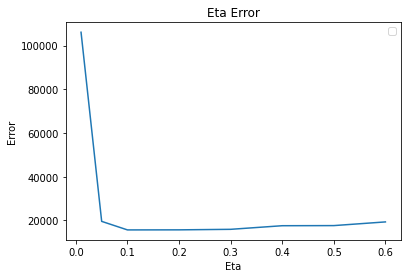

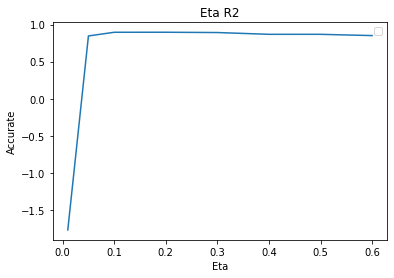

In [18]:
eta=[.01, .05, .1, .2, .3, .4, .5, .6]
listMSE=[]
listR2=[]

for e in eta:
    regressor = xgb.XGBRegressor(
        n_estimators=50,
        reg_lambda=1,
        gamma=0,
        max_depth=4,
        eta=e
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(eta, listMSE)
plt.title('Eta Error')
plt.ylabel('Error')
plt.xlabel('Eta')
plt.legend()
plt.show()

plt.plot(eta, listR2)
plt.title('Eta R2')
plt.ylabel('Accurate')
plt.xlabel('Eta')
plt.legend()
plt.show()

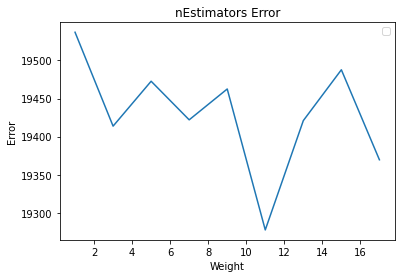

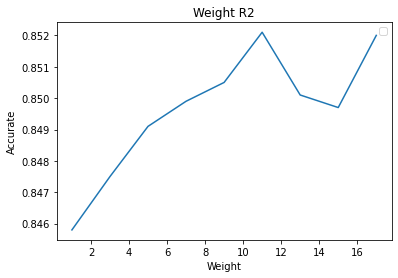

In [19]:
weight=[1, 3, 5, 7, 9, 11, 13, 15, 17]
listMSE=[]
listR2=[]

for w in weight:
    regressor = xgb.XGBRegressor(
        n_estimators=50,
        reg_lambda=1,
        gamma=0,
        max_depth=4,
        eta=.05,
        min_child_weight=w
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(weight, listMSE)
plt.title('nEstimators Error')
plt.ylabel('Error')
plt.xlabel('Weight')
plt.legend()
plt.show()

plt.plot(weight, listR2)
plt.title('Weight R2')
plt.ylabel('Accurate')
plt.xlabel('Weight')
plt.legend()
plt.show()

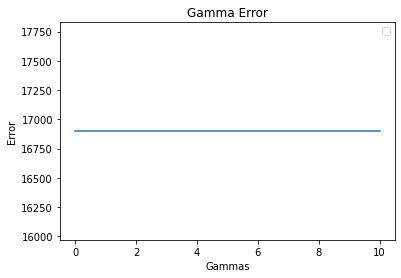

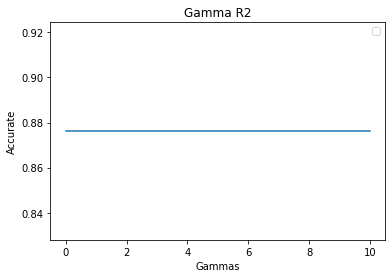

In [20]:
gammas=[0, 0.25, 0.5, 1.0, 3, 5, 10]
listMSE=[]
listR2=[]

for g in gammas:
    regressor = xgb.XGBRegressor(
        gamma=g,
        n_estimators=50,
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(gammas, listMSE)
plt.title('Gamma Error')
plt.ylabel('Error')
plt.xlabel('Gammas')
plt.legend()
plt.show()

plt.plot(gammas, listR2)
plt.title('Gamma R2')
plt.ylabel('Accurate')
plt.xlabel('Gammas')
plt.legend()
plt.show()

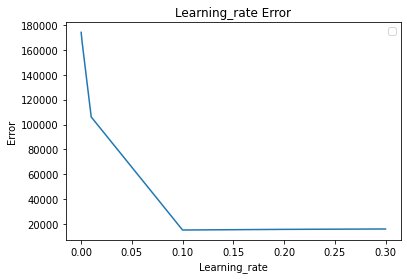

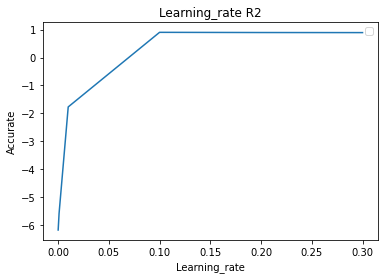

In [21]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
listMSE=[]
listR2=[]

for l in learning_rate:
    regressor = xgb.XGBRegressor(
        n_estimators=50,
        reg_lambda=1,
        gamma=g,
        max_depth=4,
        eta=.05,
        min_child_weight=13,
        learning_rate=l
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(learning_rate, listMSE)
plt.title('Learning_rate Error')
plt.ylabel('Error')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

plt.plot(learning_rate, listR2)
plt.title('Learning_rate R2')
plt.ylabel('Accurate')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

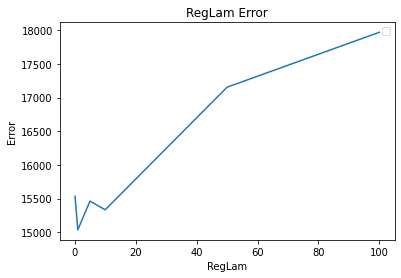

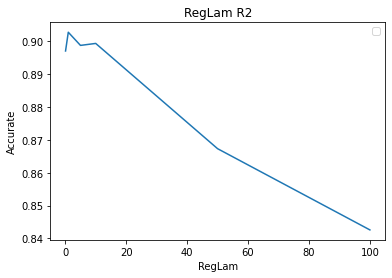

In [22]:
regLam = [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
listMSE=[]
listR2=[]

for r in regLam:
    regressor = xgb.XGBRegressor(
        n_estimators=50,
        reg_lambda=r,
        max_depth=4,
        eta=.05,
        min_child_weight=13,
        learning_rate=.1
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(regLam, listMSE)
plt.title('RegLam Error')
plt.ylabel('Error')
plt.xlabel('RegLam')
plt.legend()
plt.show()

plt.plot(regLam, listR2)
plt.title('RegLam R2')
plt.ylabel('Accurate')
plt.xlabel('RegLam')
plt.legend()
plt.show()

# Grid Search xg Boost

In [23]:
from sklearn.model_selection import GridSearchCV
import time
import warnings
warnings.filterwarnings("ignore")

start=time.time()
print("Start")

params = {
    'learning_rate':[.01, .03],
    'n_estimators':[50],
    'max_depth':[4, 5],
    'min_child_weight':[10, 13],
    'eta':[.1],
    'reg_lambda':[.01, 1]
}

boost_gs=xgb.XGBRegressor()
boost_gs=GridSearchCV(boost_gs, param_grid=params, cv=3, scoring='accuracy')
boost_gs.fit(X_train, y_train)

print(boost_gs.best_params_)
print("Done. ", time.time()-start, " seconds")

Start
{'eta': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 50, 'reg_lambda': 0.01}
Done.  9.266880512237549  seconds


#### Final xgBoost Prediction
Using best parameter tunnings

In [24]:
regressor = xgb.XGBRegressor(
    n_estimators=50,
    #gamma=0,
    max_depth=4,
    min_child_weight=10,
    reg_lambda=.01,
    eta=.1,
    learning_rate=.1
)

#regressor.fit(X_train, y_train, early_stopping_rounds=1, eval_set=[(X_test, y_test)], verbose=False)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

xgMSE=mean_absolute_error(y_test, y_pred)
xgR2 = r2_score(y_test, y_pred).round(4)
listMSE.append(xgMSE)
listR2.append(xgR2)

xgScore = regressor.score(X_test, y_test).round(4)  
xgCV = cross_validate(regressor, X, y, cv = 3, scoring= 'r2')
xgCV=xgCV['test_score'].mean().round(4)
print(xgScore)
print(xgCV)
print(abs(xgScore-xgCV))

0.9019
0.8933
0.008600000000000052


### Graph

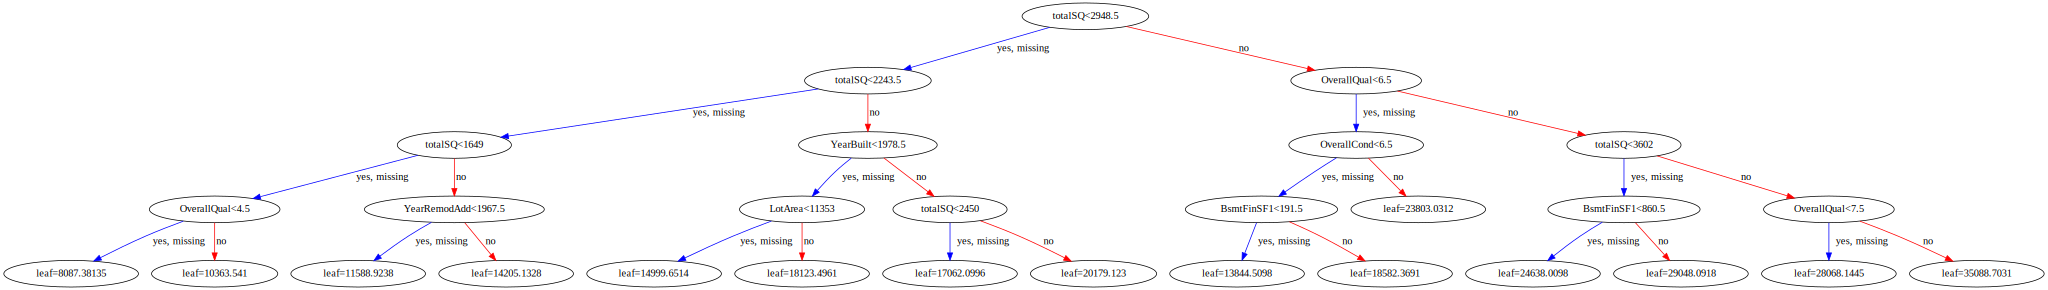

In [25]:
import graphviz
xgb.to_graphviz(regressor)

### Feature Importance

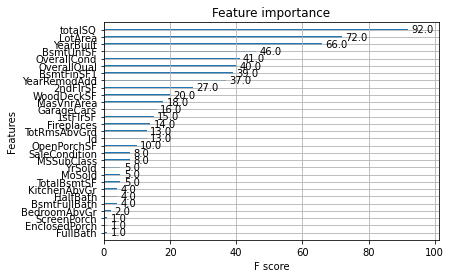

<Figure size 1440x1152 with 0 Axes>

In [26]:
xgb.plot_importance(regressor)
plt.figure(figsize = (20, 16))
plt.show()

# Test Dataset
Make final predictions on unknown house price value using features from Train data

In [27]:
test='/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
testDF=pd.read_csv(test)
print(testDF.shape)

#Missing Values
testDF=testDF.drop_duplicates()
testDF=testDF.fillna(testDF.mean())

# Feature Engineer
testDF['totalSQ']=testDF['1stFlrSF']+testDF['2ndFlrSF']+testDF['TotalBsmtSF'].drop(columns=['1stFlrSF', '2ndFlrSF', 
                'TotalBsmtSF'])
testDF['SaleCondition']=testDF['SaleCondition'].apply(lambda x:1 if x=='Normal' else 0)
testDF['Condition2']=testDF['Condition2'].apply(lambda x: 1 if x=='Norm' else 0)
testDF = testDF.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
testDF.head()

(1459, 80)


,Id,MSSubClass,LotFrontage,LotArea,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,totalSQ
0,1461,20,80.0,11622,1,5,6,1961,1961,0.0,...,0,0,0,120,0,0,6,2010,1,1778.0
1,1462,20,81.0,14267,1,6,6,1958,1958,108.0,...,36,0,0,0,0,12500,6,2010,1,2658.0
2,1463,60,74.0,13830,1,5,5,1997,1998,0.0,...,34,0,0,0,0,0,3,2010,1,2557.0
3,1464,60,78.0,9978,1,6,6,1998,1998,20.0,...,36,0,0,0,0,0,6,2010,1,2530.0
4,1465,120,43.0,5005,1,8,5,1992,1992,0.0,...,82,0,0,144,0,0,1,2010,1,2560.0


In [28]:
testIDs=testDF['Id']
cols=X_test.columns
testDF=testDF[cols]

In [29]:
#Final Prediction
finalPred=regressor.predict(testDF).round(2)
tupDF=list(zip(testIDs,finalPred))

In [30]:
output=pd.DataFrame(tupDF, columns=['Id','SalePrice']).sort_values(by='Id').reset_index(drop=True)
output.head()

,Id,SalePrice
0,1461,128146.117188
1,1462,169044.281250
2,1463,180725.265625
3,1464,182763.937500
4,1465,175877.843750


In [31]:
print(output.shape)
output.to_csv('submission.csv', index=False)
print("Output Created")

(1459, 2)
Output Created
